The link to the github repo to which this notebook is posted can be found [here](https://github.com/lilay-hagos/ML2)





# Covid Positivity prediction through chest X-ray image classification

This projects uses a range of different image classificatio neural network architectures to predict whether a person is infected with COVID-19, Pneumonia, or neither.

These model can help healthcare professionals quickly and accurately diagnose patients with respiratory illnesses, and may also be used as a validation technique to help ascertain diagnoses. The COVID-19 pandemic has demonstrated the importance of quickly identifying and isolating infected individuals to prevent the spread of disease. 

Furthermore,  these models can help healthcare systems to efficiently allocate resources. Since pneumonia and COVID-19 have similar symptoms, it can be difficult to determine the appropriate level of care needed. If a model can accurately predict whether a patient has COVID-19 or pneumonia, or neither, it can help hospitals to better allocate resources, such as ventilators and ICU beds, based on the severity of the illness.




The original dataset came from this paper:

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145



In [1]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [22]:
# Load libraries 

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.keras import backend as K


In [4]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-1513.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1893.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2124.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1531.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-231.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-722.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-941.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3349.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1287.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-979.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1519.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3102.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-54.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-358.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2056.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-

In [5]:
#Reduce number of images to first 1344 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Trying preprocessor function on single covid file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [7]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [8]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one

4032
(4032, 192, 192, 3)
-0.0
1.0


In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )




number of images for each category: [1344, 1344, 1344]
4032


In [10]:
# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


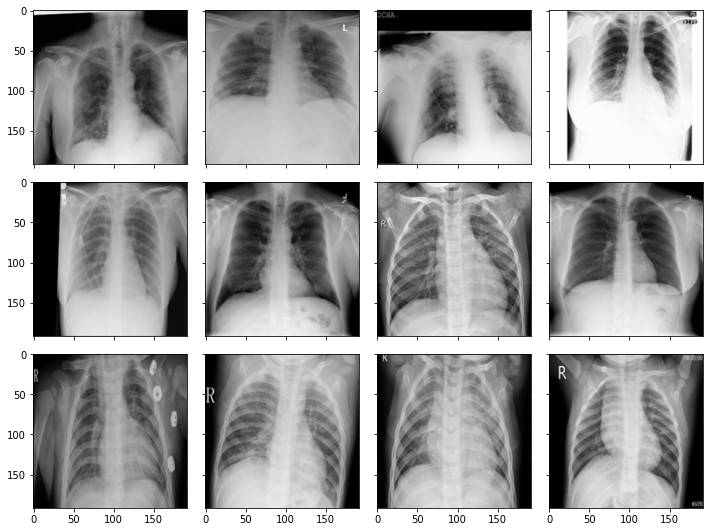

In [11]:
#visualizing sample images of all three classes

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[0][2])
im4 =preprocessor(fnames[0][3])
im5 =preprocessor(fnames[1][0])
im6 =preprocessor(fnames[1][1])
im7 =preprocessor(fnames[1][2])
im8 =preprocessor(fnames[1][3])
im9 =preprocessor(fnames[2][0])
im10 =preprocessor(fnames[2][1])
im11 =preprocessor(fnames[2][2])
im12 =preprocessor(fnames[2][3]) 

fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 4),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6, im7, im8, im9, im10, im11, im12]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [13]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [14]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

I am now ready to set up my first model architecture to predict. My first model will be a a fully connected Neural Network that has 6 hidden layers. Given that this is an image classification problem, I will use Convolutional neural networks later on, but I want to start with a fully connected Neural Network to have a baseline from which I can build off of

In [15]:
# define the model
model_1 = Sequential([
    Flatten(input_shape=(192, 192, 3)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])




In [16]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 110592)            0         
                                                                 
 dense (Dense)               (None, 512)               56623616  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 9

In [17]:
# compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I will now fit my model architecture on my training data and then evaluate the model on test data. I will be using 10 epochs on all models for sake of equal comparison.

In [18]:
  # Fitting the CNN to the Training set
  model_1.fit(X_train, y_train, 
                    epochs = 10, verbose=1,validation_split=.2)

Epoch 1/10
69/69 [==============================] - 5s 17ms/step - loss: 3.3006 - accuracy: 0.5415 - val_loss: 0.9109 - val_accuracy: 0.6576
Epoch 2/10
69/69 [==============================] - 1s 9ms/step - loss: 0.7899 - accuracy: 0.7085 - val_loss: 0.8056 - val_accuracy: 0.6849
Epoch 3/10
69/69 [==============================] - 1s 10ms/step - loss: 0.7993 - accuracy: 0.7126 - val_loss: 0.7252 - val_accuracy: 0.7341
Epoch 4/10
69/69 [==============================] - 1s 9ms/step - loss: 0.6806 - accuracy: 0.7258 - val_loss: 0.5020 - val_accuracy: 0.7760
Epoch 5/10
69/69 [==============================] - 1s 10ms/step - loss: 0.6782 - accuracy: 0.7245 - val_loss: 0.5816 - val_accuracy: 0.7104
Epoch 6/10
69/69 [==============================] - 1s 10ms/step - loss: 0.4806 - accuracy: 0.7906 - val_loss: 0.6786 - val_accuracy: 0.6648
Epoch 7/10
69/69 [==============================] - 1s 10ms/step - loss: 0.4733 - accuracy: 0.8016 - val_loss: 0.4044 - val_accuracy: 0.8106
Epoch 8/10
69/6

In [19]:
score = model_1.evaluate(X_test, y_test)
print(score)


41/41 [==============================] - 0s 6ms/step - loss: 0.4915 - accuracy: 0.7862
[0.49149927496910095, 0.7862122654914856]


In [20]:
#We will now save our model to an h5 object to call on it later when submitting to the competition
model_1.save("model_1.h5", save_format="h5")

### In our first model, an FC NN, we achieved a 78.62% accuracy on test data.

We will now experiment with  convolutional NN architectures to try and improve our validation accuracy


In [23]:
K.clear_session() #clearing session to release any resources used by the previous model


In [24]:
  model_2 = tf.keras.Sequential([   
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

In [25]:
  model_2.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

In [26]:
  model_2.fit(X_train, y_train, 
                    epochs = 10, verbose=1,validation_split=.2)

Epoch 1/10
69/69 [==============================] - 6s 25ms/step - loss: 0.7613 - accuracy: 0.6588 - val_loss: 0.5516 - val_accuracy: 0.7377
Epoch 2/10
69/69 [==============================] - 1s 16ms/step - loss: 0.4438 - accuracy: 0.8161 - val_loss: 0.3461 - val_accuracy: 0.8634
Epoch 3/10
69/69 [==============================] - 1s 16ms/step - loss: 0.3462 - accuracy: 0.8627 - val_loss: 0.3345 - val_accuracy: 0.8652
Epoch 4/10
69/69 [==============================] - 1s 16ms/step - loss: 0.2902 - accuracy: 0.8923 - val_loss: 0.3022 - val_accuracy: 0.8962
Epoch 5/10
69/69 [==============================] - 1s 17ms/step - loss: 0.2225 - accuracy: 0.9092 - val_loss: 0.3470 - val_accuracy: 0.8780
Epoch 6/10
69/69 [==============================] - 1s 16ms/step - loss: 0.1851 - accuracy: 0.9311 - val_loss: 0.2532 - val_accuracy: 0.8998
Epoch 7/10
69/69 [==============================] - 1s 16ms/step - loss: 0.1529 - accuracy: 0.9416 - val_loss: 0.2747 - val_accuracy: 0.9126
Epoch 8/10
69

In [27]:
score_2 = model_2.evaluate(X_test, y_test)
print(score_2)

41/41 [==============================] - 0s 10ms/step - loss: 0.4260 - accuracy: 0.9001
[0.4260465204715729, 0.9000774621963501]


With our first Convolutional Neural Network, we were able to achieve a relatively high accuracy of 90% test data

In [28]:
model_2.save("model_2.h5", save_format="h5")


---



---



---




We will now attempt to use pre-trained weights/transfer learning to try to further increase our accuracy on test data

In [27]:
#restarting run time as ram usage is too high
# Open the file in binary mode
import pickle

with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [29]:
K.clear_session() #clearing session to release any resources used by the previous model


In [32]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

Here we can see that the number of trainable parameters is the same as total parameters, and there are 14..7 million of them. We don't want to train those parameters as they are already pre-trained for us and have achieved high scores. We want to freeze those parameters, and train on only our own parameters.

In [33]:
vgg.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [34]:
flat1 = Flatten()(vgg.layers[-1].output)
class1 = Dense(32, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model_3 = Model(inputs=vgg.input, outputs=output)

model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

There are now only around 590 thousand trainable parameters.

In [35]:
model_3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [36]:
    model_3.fit(X_train, y_train,batch_size=1,
          epochs = 10, verbose=1,validation_split=.2)


Epoch 1/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1211 - acc: 0.3467 - val_loss: 1.1039 - val_acc: 0.3206
Epoch 2/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1009 - acc: 0.3221 - val_loss: 1.1010 - val_acc: 0.3206
Epoch 3/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1008 - acc: 0.3271 - val_loss: 1.1009 - val_acc: 0.3206
Epoch 4/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1006 - acc: 0.3303 - val_loss: 1.0994 - val_acc: 0.3388
Epoch 5/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1008 - acc: 0.3321 - val_loss: 1.1027 - val_acc: 0.3206
Epoch 6/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1015 - acc: 0.3152 - val_loss: 1.0997 - val_acc: 0.3206
Epoch 7/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1003 - acc: 0.3298 - val_loss: 1.0995 - val_acc: 0.3406
Epoch 8/10
2192/2192 [==============================] -

In [37]:
model_3.save("model_3.h5", save_format="h5")

In [38]:
score_3 = model_3.evaluate(X_test, y_test)
print(score_3)

41/41 [==============================] - 2s 21ms/step - loss: 1.1009 - acc: 0.3338
[1.100915789604187, 0.3338497281074524]


Our transfer learning model did not perform any better than random, at a validation accuracy of 33.38%. This could be for a host of different reasons e.g. the pre-trained models may require more data, the model may require more fine-tuning, or that the model/weights itself may not be appropriate because the task it was trained on was too dissimilar to ours. I will also trty fitting other pre-trained models as well as adding my own architecture from earlier to increase my validation accuracy


---

I will first submit these models to the aimodelshare competition

In [ ]:
! pip install aimodelshare --upgrade


In [40]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [4]:
import tensorflow as tf

model_1 = tf.keras.models.load_model('model_1.h5',compile=False)
model_1.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

model_2 = tf.keras.models.load_model('model_2.h5',compile=False)
model_2.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

model_3 = tf.keras.models.load_model('model_3.h5',compile=False)
model_3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])



In [5]:
# Save tf.keras model (or any tensorflow model) to local ONNX file

from aimodelshare.aimsonnx import model_to_onnx

onnx_model_1 = model_to_onnx(model_1, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

onnx_model_2 = model_to_onnx(model_2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

onnx_model_3 = model_to_onnx(model_3, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model_1.onnx", "wb") as f:
    f.write(onnx_model_1.SerializeToString())

with open("model_2.onnx", "wb") as f:
    f.write(onnx_model_1.SerializeToString())

with open("model_3.onnx", "wb") as f:
    f.write(onnx_model_1.SerializeToString())

In [6]:


prediction_column_index_1=model_1.predict(X_test).argmax(axis=1)
prediction_column_index_2=model_2.predict(X_test).argmax(axis=1)
prediction_column_index_3=model_3.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels_1 = [y_train.columns[i] for i in prediction_column_index_1]
prediction_labels_2 = [y_train.columns[i] for i in prediction_column_index_2]
prediction_labels_3 = [y_train.columns[i] for i in prediction_column_index_3]



41/41 [==============================] - 8s 142ms/step


In [7]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [8]:
experiment.submit_model(model_filepath = "model_1.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_1)



/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 440

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [9]:
experiment.submit_model(model_filepath = "model_2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_2)


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): h
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 441

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [10]:
experiment.submit_model(model_filepath = "model_3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_3)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 442

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [11]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

I will now try to build on these models and try to further imporove my accuracy scores

In [41]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

K.clear_session()


# load model new input layer shape.


# Create the base model from the pre-trained model VGG16
resnet = ResNet50(input_shape=(192, 192, 3), include_top=False, weights='imagenet')

94765736/94765736 [==============================] - 3s 0us/step


In [42]:
resnet.trainable = False

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(resnet.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)

model_4 = Model(inputs=resnet.inputs, outputs=output)
# summarize
model_4.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']         

In [44]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

In [45]:
model_4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])


model_4.fit(X_train, y_train,batch_size=1, 
            epochs = 10, verbose=1,validation_split=.2,callbacks=[mc,red_lr])


Epoch 1/10
2192/2192 [==============================] - ETA: 0s - loss: 4.1172 - acc: 0.3362
Epoch 00001: val_acc improved from -inf to 0.34062, saving model to best_model.h5
2192/2192 [==============================] - 34s 14ms/step - loss: 4.1172 - acc: 0.3362 - val_loss: 3.9323 - val_acc: 0.3406 - lr: 0.0100
Epoch 2/10
2189/2192 [============================>.] - ETA: 0s - loss: 3.7244 - acc: 0.3467
Epoch 00002: val_acc did not improve from 0.34062
2192/2192 [==============================] - 29s 13ms/step - loss: 3.7277 - acc: 0.3463 - val_loss: 3.5959 - val_acc: 0.3388 - lr: 0.0100
Epoch 3/10
2190/2192 [============================>.] - ETA: 0s - loss: 3.5442 - acc: 0.3607
Epoch 00003: val_acc did not improve from 0.34062

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
2192/2192 [==============================] - 29s 13ms/step - loss: 3.5439 - acc: 0.3604 - val_loss: 3.8580 - val_acc: 0.3406 - lr: 0.0100
Epoch 4/10
2188/2192 [=======================

In [46]:
score_4 = model_4.evaluate(X_test, y_test)


41/41 [==============================] - 2s 21ms/step - loss: 1.2927 - acc: 0.4593


In [47]:
print(score_4)

[1.2926567792892456, 0.4593338370323181]


In [48]:
model_4.save("model_4.h5", save_format="h5")

Using the ResNet50 architecture with global average pooling and no further hidden layers resulted in an accuracy score of just around 45.93%, which while better than random, is far below the standard set by our previous simple architectures. I suppose this is either because the ResNet50 architecture is not well suited to this task, or because it might require far more epochs to train the model well enough to extract predictive power. I will now combine the convolutional NN architecture from earlier with the ResNet50 architecture as the input.

In [59]:
K.clear_session()

In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

base_model = ResNet50(input_shape=(192, 192, 3), include_top=False, weights='imagenet') 
base_model.trainable = False


model_5 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    #tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    #tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    #tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [61]:
model_5.fit(X_train, y_train,batch_size=1, 
            epochs = 10, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

Epoch 1/10
2190/2192 [============================>.] - ETA: 0s - loss: 1.1027 - accuracy: 0.3338
Epoch 00001: val_accuracy improved from -inf to 0.33880, saving model to best_model.h5
2192/2192 [==============================] - 44s 18ms/step - loss: 1.1027 - accuracy: 0.3335 - val_loss: 1.0987 - val_accuracy: 0.3388 - lr: 0.0010
Epoch 2/10
2190/2192 [============================>.] - ETA: 0s - loss: 1.0992 - accuracy: 0.3256
Epoch 00002: val_accuracy did not improve from 0.33880
2192/2192 [==============================] - 37s 17ms/step - loss: 1.0992 - accuracy: 0.3253 - val_loss: 1.0986 - val_accuracy: 0.3388 - lr: 0.0010
Epoch 3/10
2190/2192 [============================>.] - ETA: 0s - loss: 1.0993 - accuracy: 0.3215
Epoch 00003: val_accuracy did not improve from 0.33880
2192/2192 [==============================] - 37s 17ms/step - loss: 1.0993 - accuracy: 0.3216 - val_loss: 1.0987 - val_accuracy: 0.3206 - lr: 0.0010
Epoch 4/10
2192/2192 [==============================] - ETA: 0s -

In [62]:
score_5 = model_5.evaluate(X_test, y_test)
print(score_5)

41/41 [==============================] - 2s 18ms/step - loss: 1.0986 - accuracy: 0.3338
[1.0986140966415405, 0.3338497281074524]


In [63]:
model_5.save("model_5.h5", save_format="h5")

Unsurprisingly, this model was unable to predict any better than random. I suspect this is because the model architecture either too complicated or has too few epochs, or because the ResNet50 architecture is not well suited to this task. I will now attempt to use the DenseNet architecture which is often used in medical image analysis.

In [64]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

K.clear_session()

# create the base model with pre-trained weights on ImageNet
base_model = DenseNet121(include_top=False, input_shape=(192, 192, 3), weights='imagenet')
base_model.trainable = False
# create a Sequential model with the base model as the first layer, global average pooling layer as the second layer, and dense output layer as the third layer
model_6 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(3, activation='softmax')
])



# compile the model with categorical cross-entropy loss and Adam optimizer
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [65]:
  model_6.fit(X_train, y_train, 
                    epochs = 10, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

Epoch 1/10
67/69 [============================>.] - ETA: 0s - loss: 0.7056 - accuracy: 0.6754
Epoch 00001: val_accuracy improved from 0.34062 to 0.77778, saving model to best_model.h5
69/69 [==============================] - 11s 74ms/step - loss: 0.6967 - accuracy: 0.6807 - val_loss: 0.4948 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 2/10
68/69 [============================>.] - ETA: 0s - loss: 0.4176 - accuracy: 0.8212
Epoch 00002: val_accuracy improved from 0.77778 to 0.80692, saving model to best_model.h5
69/69 [==============================] - 3s 42ms/step - loss: 0.4153 - accuracy: 0.8225 - val_loss: 0.4166 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 3/10
67/69 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8456
Epoch 00003: val_accuracy improved from 0.80692 to 0.84335, saving model to best_model.h5
69/69 [==============================] - 3s 40ms/step - loss: 0.3561 - accuracy: 0.8458 - val_loss: 0.3804 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 4/10
68/69 [

In [66]:
score_6 = model_6.evaluate(X_test, y_test)
print(score_6)

41/41 [==============================] - 1s 35ms/step - loss: 0.2647 - accuracy: 0.8877
[0.264708012342453, 0.8876839876174927]


In [67]:
model_6.save("model_6.h5", save_format="h5")

The DenseNet architecture was able to predict at around 88.77% accuracy, which is comparable performance to the first convolutional architecture I tried but with far more hidden layers

In [69]:
import aimodelshare as ai
from aimodelshare.aimsonnx import model_to_onnx
from aimodelshare.aws import set_credentials

onnx_model_4 = model_to_onnx(model_4, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

onnx_model_5 = model_to_onnx(model_5, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

onnx_model_6 = model_to_onnx(model_6, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model_4.onnx", "wb") as f:
    f.write(onnx_model_1.SerializeToString())

with open("model_5.onnx", "wb") as f:
    f.write(onnx_model_1.SerializeToString())

with open("model_6.onnx", "wb") as f:
    f.write(onnx_model_1.SerializeToString())

prediction_column_index_4=model_4.predict(X_test).argmax(axis=1)
prediction_column_index_5=model_5.predict(X_test).argmax(axis=1)
prediction_column_index_6=model_6.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels_4 = [y_train.columns[i] for i in prediction_column_index_4]
prediction_labels_5 = [y_train.columns[i] for i in prediction_column_index_5]
prediction_labels_6 = [y_train.columns[i] for i in prediction_column_index_6]

apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

experiment= ai.Experiment(apiurl)

set_credentials(apiurl=apiurl)




Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f075e65e280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f0780c52af0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source c

In [70]:
experiment.submit_model(model_filepath = "model_4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_4)


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 444

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [71]:
experiment.submit_model(model_filepath = "model_5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_5)


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 445

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [72]:
experiment.submit_model(model_filepath = "model_6.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_6)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 446

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


I will now try augmenting the image data to effectively increase the size and variability of our training dataset to extract more predictive power.

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [75]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

filenamelist=fnames[0]+fnames[1]+fnames[2]
len(filenamelist)

4032

In [81]:
filenamelist[1340:1348]

['COVID-19_Radiography_Dataset/COVID/images/COVID-2188.png',
 'COVID-19_Radiography_Dataset/COVID/images/COVID-1780.png',
 'COVID-19_Radiography_Dataset/COVID/images/COVID-97.png',
 'COVID-19_Radiography_Dataset/COVID/images/COVID-526.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-2359.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-4675.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-334.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-8298.png']

In [91]:
from itertools import repeat

covid=list(repeat("covid", 1344))
normal=list(repeat("normal", 1344))
pneumonia=list(repeat("pneumonia", 1344))


#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
len(y_labels)



4032

In [92]:
from sklearn.model_selection import train_test_split

X_train_datagen,X_test_datagen,y_train_datagen,y_test_datagen=train_test_split(filenamelist,y_labels,test_size=0.40,random_state=42)

print(X_train_datagen[0:5])
y_train_datagen[0:5] 

['COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-568.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-84.png', 'COVID-19_Radiography_Dataset/Normal/images/Normal-6805.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-486.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-770.png']


['pneumonia', 'pneumonia', 'normal', 'pneumonia', 'pneumonia']

In [93]:
set(y_labels)

{'covid', 'normal', 'pneumonia'}

In [94]:
import pandas as pd
trainingdata=pd.DataFrame.from_dict({'X': X_train_datagen, 'y': y_train_datagen})
testdata=pd.DataFrame.from_dict({'X': X_test_datagen, 'y': y_test_datagen})

trainingdata.head()

,X,y
0,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,pneumonia
1,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,pneumonia
2,COVID-19_Radiography_Dataset/Normal/images/Nor...,normal
3,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,pneumonia
4,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,pneumonia


In [95]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.5,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        directory=None,
        x_col="X", # Actual column names from data
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical',
        shuffle=True,
        # List of labels for each class
        classes=['covid', 'normal', 'pneumonia'])



Found 2419 validated image filenames belonging to 3 classes.


In [96]:
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=testdata,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical',
        classes = ['covid', 'normal', 'pneumonia'])

Found 1613 validated image filenames belonging to 3 classes.


Now that I have set up my augmented training and testing data, I will use my most predictive model from earlier on the new dataset

In [98]:
  model_7 = tf.keras.Sequential([   
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

In [99]:
adam=Adam(lr=0.001)

In [100]:
  model_7.compile(
    optimizer=adam, 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

In [101]:
      model_7.fit(train_generator,
                    steps_per_epoch=len(trainingdata) / 1, epochs=10, 
                    validation_data=validation_generator, callbacks=[mc,red_lr])

Epoch 1/10
2418/2419 [============================>.] - ETA: 0s - loss: 0.9535 - accuracy: 0.5215
Epoch 00001: val_accuracy did not improve from 0.89253
2419/2419 [==============================] - 31s 12ms/step - loss: 0.9536 - accuracy: 0.5213 - val_loss: 0.6741 - val_accuracy: 0.6590 - lr: 0.0010
Epoch 2/10
2417/2419 [============================>.] - ETA: 0s - loss: 0.7816 - accuracy: 0.6305
Epoch 00002: val_accuracy did not improve from 0.89253
2419/2419 [==============================] - 28s 12ms/step - loss: 0.7816 - accuracy: 0.6304 - val_loss: 0.7119 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 3/10
2418/2419 [============================>.] - ETA: 0s - loss: 0.7631 - accuracy: 0.6381
Epoch 00003: val_accuracy did not improve from 0.89253
2419/2419 [==============================] - 28s 12ms/step - loss: 0.7630 - accuracy: 0.6383 - val_loss: 0.7029 - val_accuracy: 0.6441 - lr: 0.0010
Epoch 4/10
2418/2419 [============================>.] - ETA: 0s - loss: 0.7106 - accuracy: 0.6663

In [107]:
model_7.evaluate(X_test, y_test)

41/41 [==============================] - 1s 8ms/step - loss: 0.5135 - accuracy: 0.7761


[0.5135349035263062, 0.7761425375938416]

In [104]:
model_7.save("model_7.h5", save_format="h5")

Using augmented data, my test data accuracy dropped from almost 90% to around 77%. This could be because the augmentation parameters of the image data added more noise than the signal it was trying to add. Experimenting with different augmentation parameters might increase the validation accuracy.

In [108]:
onnx_model_7 = model_to_onnx(model_7, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model_7.onnx", "wb") as f:
    f.write(onnx_model_1.SerializeToString())

prediction_column_index_7=model_7.predict(X_test).argmax(axis=1)

prediction_labels_7 = [y_train.columns[i] for i in prediction_column_index_7]

experiment.submit_model(model_filepath = "model_7.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_7)

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f02d6fce9d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 0s 7ms/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 447

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340
